In [32]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)

## Week 6 Homework

---

### Q1: Let's start having some *real* fun...

We previously considered the normal-gamma specification

$$\scriptsize
\begin{align*}
p(\theta,\tau|x) &\propto{} p(\theta,\tau,x) = p(x|\theta)p(\theta)p(\tau) \quad (\theta \perp\!\!\perp \tau) \leftarrow \text{independent priors} & p(\theta|x,\theta_0,\tau_0, \tau) &={} \text{N}\left(\frac{\left(\tau_0 \theta_0+\tau\sum_{i=1}^{n}x_{i}\right)}{(\tau_0+n\tau)}, \sigma^{-2}=\tau_0+n\tau \right)\\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha -1}e^{-\beta \tau} & p(\tau|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\frac{\alpha}{2}+\frac{n}{2}, \frac{\beta}{2}+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)\\{}\\
\end{align*}$$

How about instead we consider a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform" specification?

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

Um yeah we're gonna need a Metroposlis cleanup on aisles one two and three  
(or a slice or adapative squeeze rejection sampling steps... in place of Metroposlis steps)

*Implement the a Metroposlis within Gibbs algorithm to smaple from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*





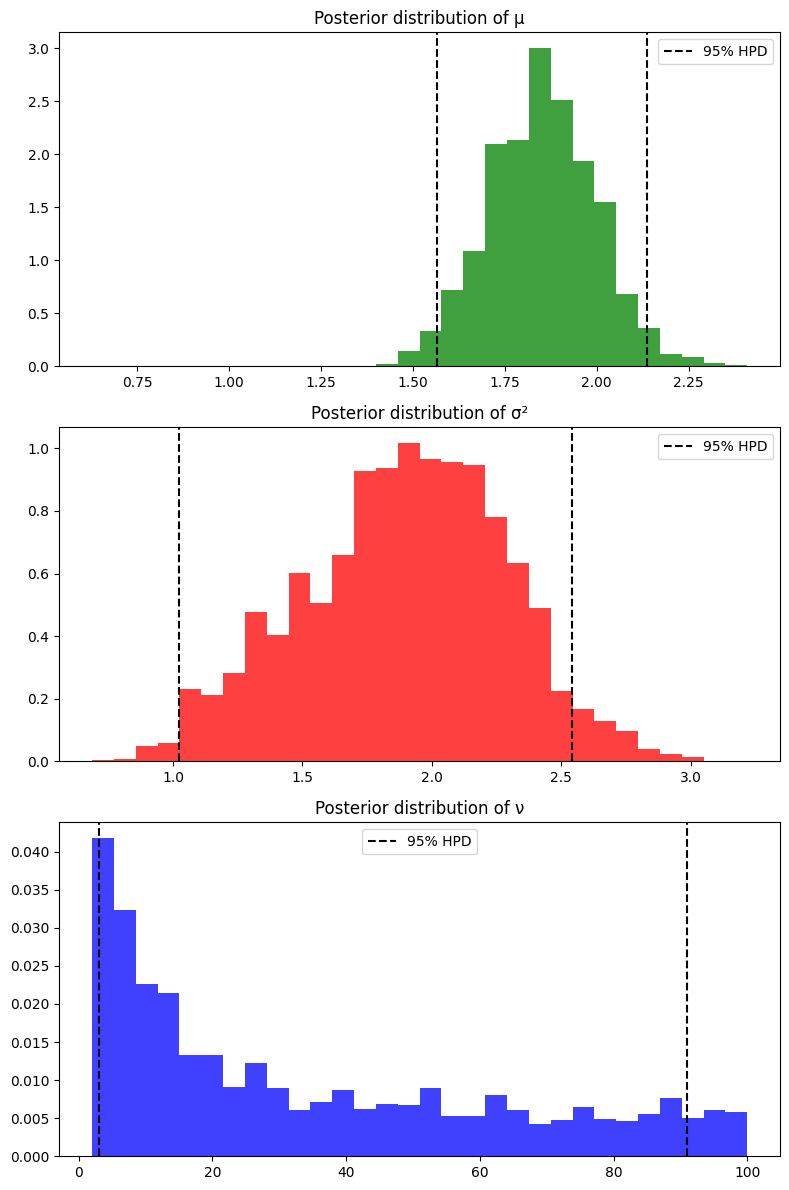

95 hpd interval for μ: (1.5647431898426645, 2.1374726094922543)
95 hpd interval for σ²: (1.0220642033242624, 2.540785137158175)
95 hpd interval for ν: (3, 91)


In [39]:
# generate parameters
def log_posterior(mu, sigma2, nu, x):
    n = len(x)
    log_prior_mu = stats.norm.logpdf(mu, loc=0, scale=np.sqrt(1))  # norm prior
    log_prior_sigma2 = np.log(2 / np.pi) - 0.5 * sigma2 ** 2  # half-norm prior
    if 1 <= nu <= 100:
      log_prior_nu = -np.log(100) # discrete uniform
    else:
      log_prior_nu = -np.inf

    log_likelihood = np.sum(stats.t.logpdf(x, df=nu, loc=mu, scale=np.sqrt(sigma2)))

    return log_likelihood + log_prior_mu + log_prior_sigma2 + log_prior_nu

# metropolis within gibbs sampler
def metropolis_within_gibbs(x, iters, mu_init=0, sigma2_init=1, nu_init=10):
    n = len(x)
    mu_samples = np.zeros(iters)
    sigma2_samples = np.zeros(iters)
    nu_samples = np.zeros(iters, dtype=int)

    mu_curr = mu_init
    sigma2_curr = sigma2_init
    nu_curr = nu_init

    for i in range(iters):
        # sample mu by mh
        mu_proposal = np.random.normal(mu_curr, 0.5)
        log_alpha_mu = log_posterior(mu_proposal, sigma2_curr, nu_curr, x) - \
                       log_posterior(mu_curr, sigma2_curr, nu_curr, x)
        if np.log(np.random.uniform()) < log_alpha_mu:
            mu_curr = mu_proposal

        # sample sigma2 by mh
        sigma2_proposal = np.abs(np.random.normal(sigma2_curr, 0.5))  # Ensure positivity
        log_alpha_sigma2 = log_posterior(mu_curr, sigma2_proposal, nu_curr, x) - \
                           log_posterior(mu_curr, sigma2_curr, nu_curr, x)
        if np.log(np.random.uniform()) < log_alpha_sigma2:
            sigma2_curr = sigma2_proposal

        # sample nu using discrete metropolis step
        nu_proposal = np.random.randint(1, 101)
        log_alpha_nu = log_posterior(mu_curr, sigma2_curr, nu_proposal, x) - \
                       log_posterior(mu_curr, sigma2_curr, nu_curr, x)
        if np.log(np.random.uniform()) < log_alpha_nu:
            nu_curr = nu_proposal

        # store samples
        mu_samples[i] = mu_curr
        sigma2_samples[i] = sigma2_curr
        nu_samples[i] = nu_curr

    return mu_samples, sigma2_samples, nu_samples

# generate true data
n = 100
tr_mu = 2
tr_sigma2 = 1.5
tr_nu = 10
x = stats.t.rvs(df=tr_nu, loc=tr_mu, scale=np.sqrt(tr_sigma2), size=n)

# call gibbs sampler
mu_samples, sigma2_samples, nu_samples = metropolis_within_gibbs(x, iters=5000)

# inference
def hpd_interval(samples, alpha=0.05):
    samples_sorted = np.sort(samples)
    n = len(samples_sorted)
    interval_index = int(np.floor(n * (1 - alpha)))
    intervals = [samples_sorted[i:i + interval_index] for i in range(n - interval_index)]
    hpd = min(intervals, key=lambda x: x[-1] - x[0])
    return hpd[0], hpd[-1]

mu_hpd = hpd_interval(mu_samples)
sigma2_hpd = hpd_interval(sigma2_samples)
nu_hpd = hpd_interval(nu_samples)

# create plots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

axs[0].hist(mu_samples, bins=30, density=True, alpha=0.75, color='g')
axs[0].axvline(mu_hpd[0], color='k', linestyle='dashed', label="95% HPD")
axs[0].axvline(mu_hpd[1], color='k', linestyle='dashed')
axs[0].set_title("Posterior distribution of \u03BC")
axs[0].legend()

axs[1].hist(sigma2_samples, bins=30, density=True, alpha=0.75, color='r')
axs[1].axvline(sigma2_hpd[0], color='k', linestyle='dashed', label="95% HPD")
axs[1].axvline(sigma2_hpd[1], color='k', linestyle='dashed')
axs[1].set_title("Posterior distribution of \u03C3²")
axs[1].legend()

axs[2].hist(nu_samples, bins=30, density=True, alpha=0.75, color='b')
axs[2].axvline(nu_hpd[0], color='k', linestyle='dashed', label="95% HPD")
axs[2].axvline(nu_hpd[1], color='k', linestyle='dashed')
axs[2].set_title("Posterior distribution of \u03BD")
axs[2].legend()

plt.tight_layout()
plt.show()

# print hpd intervals
print(f"95 hpd interval for \u03BC: {mu_hpd}")
print(f"95 hpd interval for \u03C3²: {sigma2_hpd}")
print(f"95 hpd interval for \u03BD: {nu_hpd}")

### Q2: explore the role of sample size in providing inference for the degrees of freedom parameter $\nu$

*Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.*

In [40]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

Output()

Output()

Output()

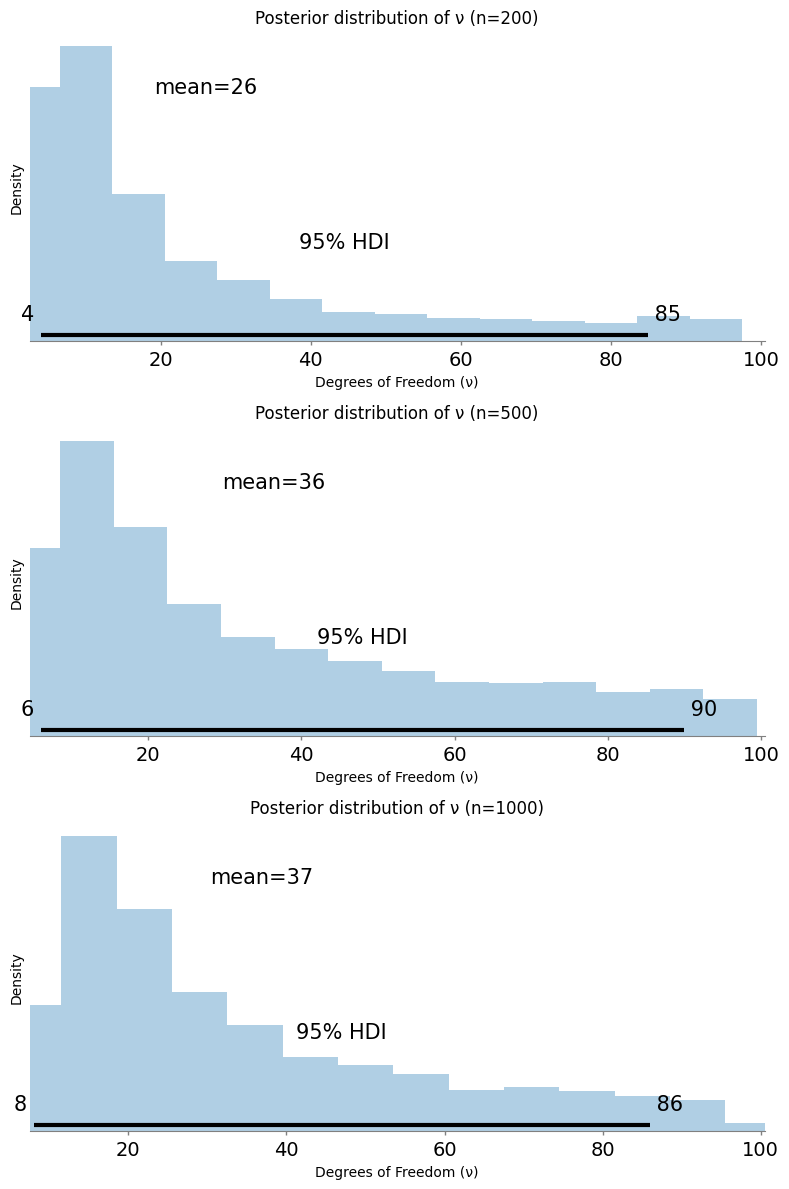

summary for sample size 200:
  mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
25.979 23.73     3.0     80.0      1.771    1.326     250.0     267.0    1.0
summary for sample size 500:
  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
36.367 26.039     6.0     88.0      1.399     0.99     281.0     348.0   1.01
summary for sample size 1000:
  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
36.806 23.115     8.0     84.0      1.202     0.85     384.0     688.0    1.0


In [47]:
np.random.seed(42)

# bayesian inference on v for different sample sizes
def bayesian_inference_on_v(sample_size, true_mu=2, true_sigma2=1.5, true_nu=10, draws=3000):
    x = np.random.standard_t(df=true_nu, size=sample_size) * np.sqrt(true_sigma2) + true_mu

    with pm.Model() as model:
        mu = pm.Normal("mu", mu=0, sigma=1)
        sigma = pm.HalfNormal("sigma", sigma=1)
        nu = pm.DiscreteUniform("nu", lower=1, upper=100)

        likelihood = pm.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=x)

        trace = pm.sample(draws, tune=1000, return_inferencedata=True, cores=2)

    return trace

# adjusted sample sizes to improve posterior visualization
sample_sizes = [200, 500, 1000]
inference_results = {}
for n in sample_sizes:
    inference_results[n] = bayesian_inference_on_v(n)

# extract posterior samples correctly and improve visualization
fig, axes = plt.subplots(3, 1, figsize=(8, 12))
for idx, n in enumerate(sample_sizes):
    az.plot_posterior(inference_results[n].posterior["nu"], ax=axes[idx], hdi_prob=0.95)
    axes[idx].set_title(f"Posterior distribution of \u03BD (n={n})")
    axes[idx].set_xlabel("Degrees of Freedom (\u03BD)")
    axes[idx].set_ylabel("Density")
plt.tight_layout()
plt.show()

# summarize results and format output
for n in sample_sizes:
    summary = az.summary(inference_results[n], var_names=["nu"], hdi_prob=0.94)

    # Select only relevant columns
    summary = summary[["mean", "sd", "hdi_3%", "hdi_97%", "mcse_mean", "mcse_sd", "ess_bulk", "ess_tail", "r_hat"]]

    print(f"summary for sample size {n}:")
    print(summary.to_string(index=False))

### Q3: the posterior predictive distribution does something like the following...

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$ and now integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

*Go look at the gamma distribution and remember that you know that the integrals of unnormalized densities are the inverse of their normalizing constants. Then go look at the t distribution and determine what distribution the following expression defines. Then explain why the behavior demonstrated here is analagous to that of the posterior predictive distribution.*

$$\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i$$



This integral simplifies to a Student's t-Distribution when when integrating out the uncertainty in 𝜏$_i$. Consequently, the posterior predictive distribution of a normal model with an unknown variance follows a Student's t-Distribution, where the heavy tails account for the additional uncertainty in variance estimation.

This behavior aligns with Bayesian posterior predictive inference, as predicting new observations in Bayesian inference involves integrating over parameter uncertainty.

References: Generated/debugged some sections of code using OpenAI.